In [1]:
import os

import h5py
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import vmap, config

from jax_sph.kernel import QuinticKernel
from jax_sph.turbulence import (
    M4PrimeKernel,
    FourierQuinticKernel,
    get_energy_spectrum,
    pbc_copy_vector,
    pbc_copy_scalar,
    mls_2nd_order,
)

EPS = jnp.finfo(float).eps
config.update("jax_enable_x64", True)

Calculate kernel and its fourier transform

In [27]:
t_size = 50
t = np.linspace(0, 3, t_size)
k = np.linspace(1, 11, 500)
kernels = [(M4PrimeKernel, 1), (QuinticKernel, 1)]
fourier_kernel = FourierQuinticKernel(1, 1)
w = []
w_fourier = []
w_fourier_r = []
for j in kernels:
    kernel_fn = j[0](j[1], 1)
    temp = vmap(kernel_fn.w)(np.abs(t))
    w.append(temp)
    w_fourier.append(np.fft.fft(temp))

w_fourier_ana = fourier_kernel.w(k)

N = len(w_fourier[0])
n = np.arange(1,N+1)

Show M4' kernel versus quintic spline kernel in physical and fourier domain

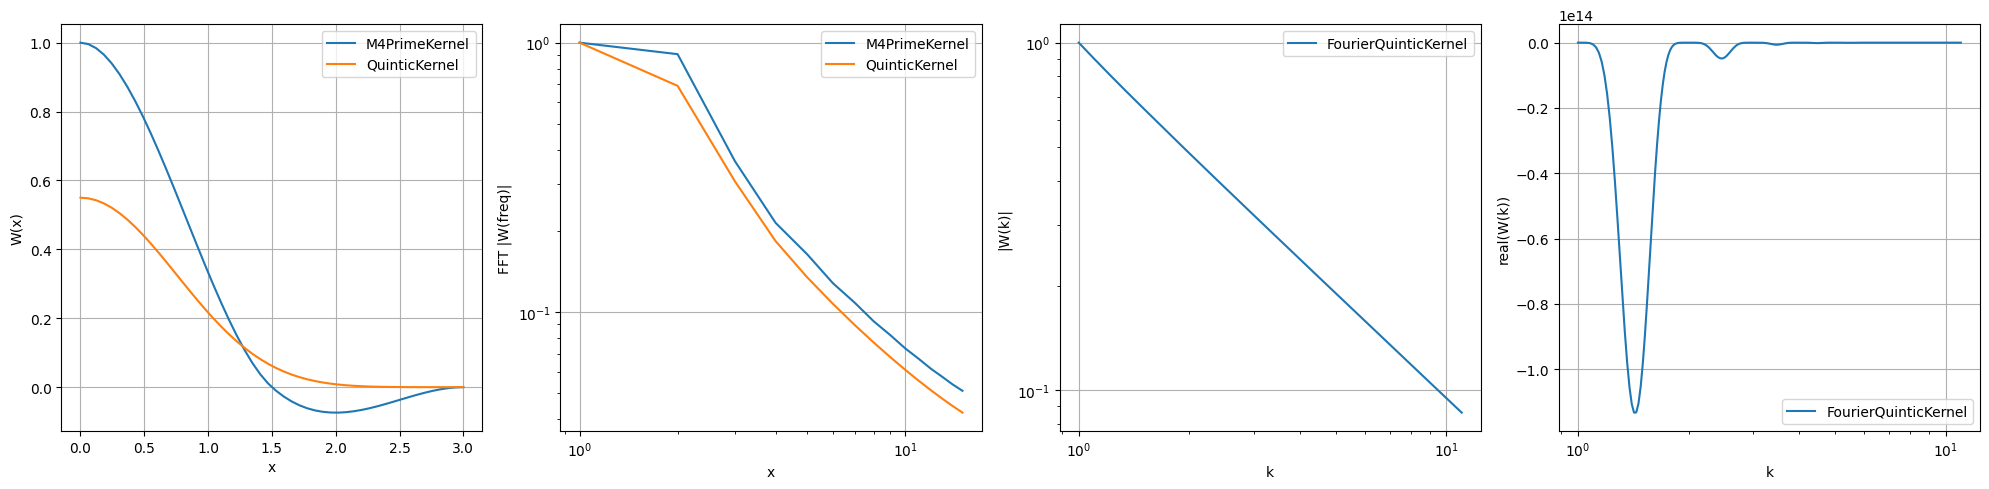

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(jnp.shape(w)[0]):
    axs[0].plot(t, w[i], label=str(kernels[i][0].__name__))
    axs[1].plot(n[:15], np.abs(w_fourier[i])[:15] / np.abs(w_fourier[i][0]), label=str(kernels[i][0].__name__))

axs[2].plot(k, np.abs(w_fourier_ana) / np.abs(w_fourier_ana[0]), label=str(fourier_kernel.__class__.__name__))
axs[3].plot(k, np.real(w_fourier_ana) / np.real(w_fourier_ana[0]), label=str(fourier_kernel.__class__.__name__))

for ax in axs:
    ax.legend()
    ax.grid()

axs[0].set_xlabel("x")
axs[0].set_ylabel("W(x)")

axs[1].set_ylabel("FFT |W(freq)|")
axs[1].set_xlabel("x")
axs[1].set_yscale('log')
axs[1].set_xscale('log')

axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_ylabel("|W(k)|")
axs[2].set_xlabel("k")

axs[3].set_xscale('log')
axs[3].set_ylabel("real(W(k))")
axs[3].set_xlabel("k")

plt.tight_layout()

Energy spectrum computation in 3D and 2D

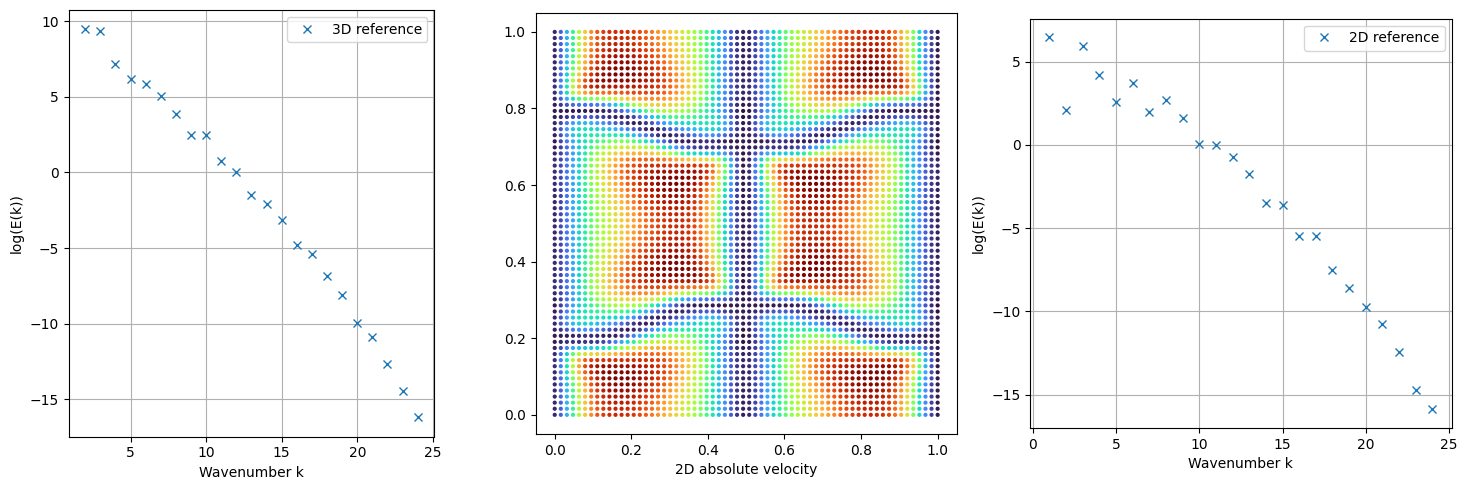

In [30]:
def mask_for_plot(masked_array):
        x = np.arange(len(masked_array))
        x = x[~masked_array.mask]
        y = masked_array.data[~masked_array.mask]
        mask2 = y > -17
        x = x[mask2]
        y = y[mask2]
        return x, y

# read velocity tensor from h5py file (5s into TGV with Re=100 on 64^3 grid),
# obtained using JAX-FLUIDS
vel = h5py.File(os.path.join("./ref_data", "tgv_vel_64.h5"), "r")["velocity"][:]

# slice for 2D solution
vel_2d = vel[:2, 0]
vel_2d_abs = np.sum(vel_2d**2, axis=0)
grid = np.linspace(0, 1, 64)
x, y = np.meshgrid(grid, grid, indexing="ij")

# compute reference energy spectrum
ek_ref_3d = get_energy_spectrum(vel)
ek_ref_2d = get_energy_spectrum(vel_2d)

# plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(*mask_for_plot(np.ma.log(ek_ref_3d)), 'x', label="3D reference")
axs[0].legend()
axs[0].set_ylabel("log(E(k))")
axs[0].set_xlabel("Wavenumber k")
axs[0].grid()
axs[0].set_aspect('equal', 'box')

axs[1].scatter(x, y, c=vel_2d_abs, cmap="turbo", s=4)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlabel("2D absolute velocity")

axs[2].plot(*mask_for_plot(np.ma.log(ek_ref_2d)), 'x', label="2D reference")
axs[2].legend()
axs[2].set_ylabel("log(E(k))")
axs[2].set_xlabel("Wavenumber k")
axs[2].grid()
axs[2].set_aspect('equal', 'box')

plt.tight_layout()

Show the functionality of the periodic boudary condition (pbc) copy functions in 1D

In [9]:
# defined parameters
dim = 1
halo = np.pi / 3
box_size = np.ones(dim) * np.pi * 2

# grid setup
t = np.linspace(0, 2 * np.pi, 10)

# calculate sin(t)
f = np.sin(t)

# copy periodic boundaries
r_pbc, f_pbc = pbc_copy_vector(t, f, box_size, halo, dim, unsorted=False)
r_pbc_scalar, f_pbc_scalar = pbc_copy_scalar(t, f, box_size, halo, dim, unsorted=False)

# print copied values
print(r_pbc)
print(r_pbc_scalar)

print(f_pbc)
print(f_pbc_scalar)

[-0.6981317   0.          0.6981317   1.3962634   2.0943951   2.7925268
  3.4906585   4.1887902   4.88692191  5.58505361  6.28318531  6.98131701]
[-0.6981317   0.          0.6981317   1.3962634   2.0943951   2.7925268
  3.4906585   4.1887902   4.88692191  5.58505361  6.28318531  6.98131701]
[-6.42787610e-01  0.00000000e+00  6.42787610e-01  9.84807753e-01
  8.66025404e-01  3.42020143e-01 -3.42020143e-01 -8.66025404e-01
 -9.84807753e-01 -6.42787610e-01 -2.44929360e-16  6.42787610e-01]
[-6.42787610e-01  0.00000000e+00  6.42787610e-01  9.84807753e-01
  8.66025404e-01  3.42020143e-01 -3.42020143e-01 -8.66025404e-01
 -9.84807753e-01 -6.42787610e-01 -2.44929360e-16  6.42787610e-01]


Show the functionality of the periodic boudary condition (pbc) copy functions in 2D

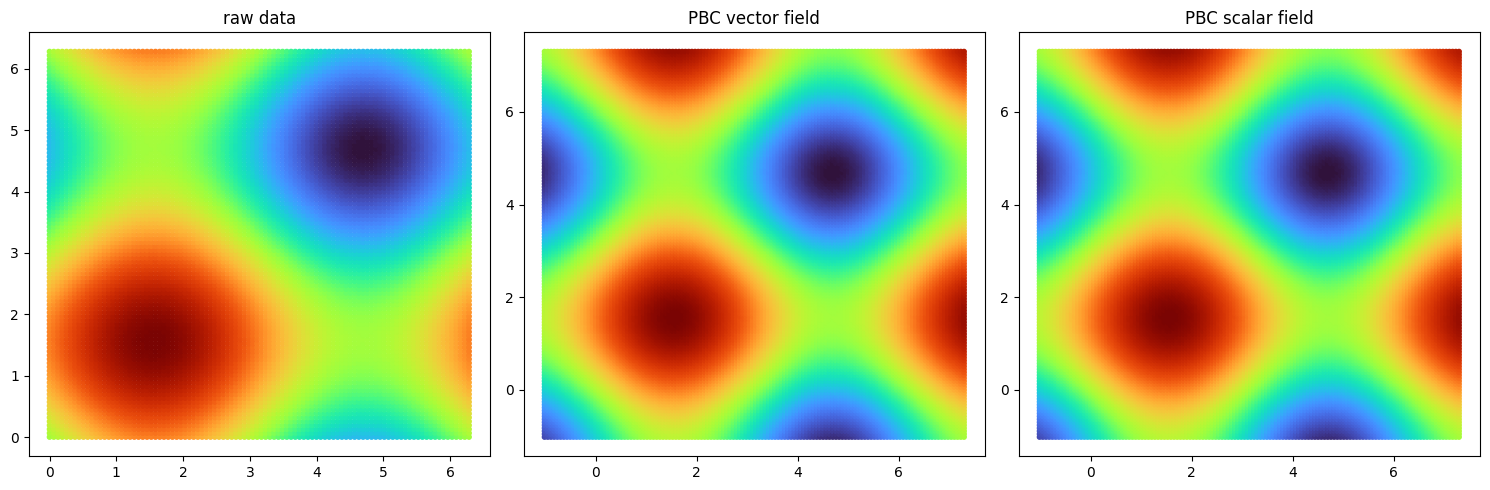

In [2]:
# defined parameters
dim = 2
halo = np.pi / 3
box_size = np.ones(dim) * np.pi * 2

# grid setup
disc = np.linspace(0, 2 * np.pi, 100)
x, y = np.meshgrid(disc, disc, indexing='ij')
r = np.vstack([x.ravel(), y.ravel()]).T

# calculate sin in x and y direction
f = np.sin(r)
# superpose for scalar field
f_sum = np.sum(f, axis=1)

# copy periodic boundaries
r_pbc, f_pbc = pbc_copy_vector(r, f, box_size, halo, dim, unsorted=False)
r_pbc_scalar, f_pbc_scalar = pbc_copy_scalar(r, f_sum, box_size, halo, dim, unsorted=False)


# plot data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(r[:, 0], r[:, 1], c=f_sum, cmap="turbo", s=10)
axs[1].scatter(r_pbc[:, 0], r_pbc[:, 1], c=np.sum(f_pbc, axis=1), cmap="turbo", s=10)
axs[2].scatter(r_pbc_scalar[:, 0], r_pbc_scalar[:, 1], c=f_pbc_scalar, cmap="turbo", s=10)
axs[0].title.set_text('raw data')
axs[1].title.set_text('PBC vector field')
axs[2].title.set_text('PBC scalar field')
fig.tight_layout()

Show the functionality of second order moving least squares (mls) interpolation

[0.         0.06342392 0.12659245 0.18925124 0.25114799 0.31203345
 0.37166246 0.42979491 0.48619674 0.54064082]
[1.07494992e-17 6.40710228e-02 1.27874830e-01 1.91153451e-01
 2.53647130e-01 3.15099023e-01 3.75256566e-01 4.33872509e-01
 4.90705937e-01 5.45523257e-01]


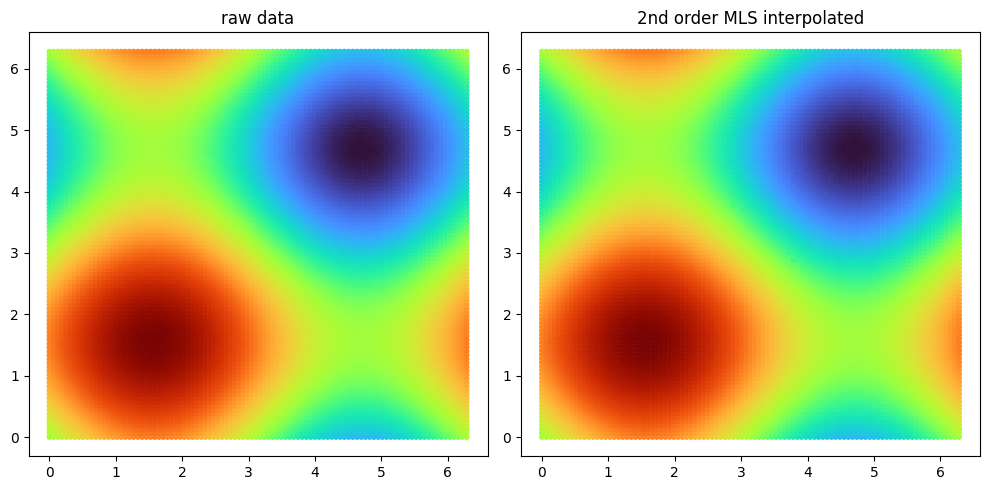

In [2]:
# defined para,eters
dim = 2
halo = np.pi / 3
box_size = np.ones(dim) * np.pi * 2

# data grid setup
dx = 2 * np.pi / 100
disc = np.linspace(0, 2 * np.pi, 100)
x, y = np.meshgrid(disc, disc, indexing='ij')
r = np.vstack([x.ravel(), y.ravel()]).T

# slightly off-grid interpolation grid setup
disc = np.linspace(0, 2 * np.pi, 99)
x, y = np.meshgrid(disc, disc, indexing='ij')
r_target = np.vstack([x.ravel(), y.ravel()]).T

# calculate sin in x and y direction
f = np.sin(r)
# superpose for scalar field
f_sum = np.sum(f, axis=1)

# inetpolate f
f_interp = mls_2nd_order(r, r_target, f_sum, box_size, dx, dim)

# print first ten values
print(f_sum[0:10])
print(f_interp[0:10])

# plot data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(r[:, 0], r[:, 1], c=f_sum, cmap="turbo", s=10)
axs[1].scatter(r_target[:, 0], r_target[:, 1], c=f_interp, cmap="turbo", s=10)
axs[0].title.set_text('raw data')
axs[1].title.set_text('2nd order MLS interpolated')
fig.tight_layout()